In [1]:
import numpy as np
import polytope as pc
from itertools import combinations

import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from best.abstraction import LTIAbstraction
from best.mdp import *
from best.policy import *

from Models.Linear import LTI

# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2) #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[0,0],[0,0.4]]) #2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None
sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

sys_n = sys_lti.normalize()

In [2]:
# Define regions of interest for the labeling
regions = dict()
regions['target'] = pc.box2poly(np.kron(np.ones((2, 1)), np.array([[5, 10]])))
# add avoid
regions['avoid'] = pc.box2poly(np.array([[-5, 3],[-10, 5]]))

In [3]:
## step 1: tune gridding ratio (find optimal horizontal d_1, and vertical d_2)
# currently only available for 2D
# d_opt, d_vals, eps_values = tune_dratio(sys_n)

d_opt = np.array([[ 0.69294],
                  [ 0.721  ]])

# d = np.array([[1.5], [1.5]])
d = d_opt

Warning no inputspace given
Warning no state space given
status: optimal
optimal epsilon 1.00000639831
optimal M [[ 1.  0.]
 [ 0.  1.]]
Optimal K [[ 0. -1.]
 [-1.  0.]]
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))


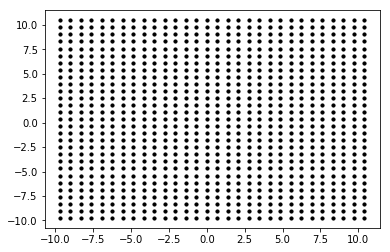

In [4]:
# mdp_grid = sys_n.abstract_io(d, un=4, verbose=False)  # do the gridding
# mdp_grid.map_dfa_inputs(dict_input2prop, regions)

abstr = LTIAbstraction(sys_n, d, un=4)
abstr.set_regions(regions)

in_regions, nin_regions = abstr.map_dfa_inputs()

fig = plt.figure()
abstr.plot(fig)

### Set up LTL problem

In [5]:
from best.ltl import solve_ltl_cosafe

formula = '( ( ! avoid U target ) & ( F avoid ) )'

def subsets(collection):
    for i in range(len(collection)+1):
        it = combinations(collection, i)
        try:
            while True:
                yield(list(next(it)))
        except StopIteration:
            pass
    raise StopIteration

def connection(s_x):
    s = s_x[0]
    if s == abstr.mdp.N-1:
        return set([ (), ])
    know_in = []
    know_out = []
    for reg in regions.keys():
        if in_regions[reg][s] == 0:
            know_out.append(reg)
        if nin_regions[reg][s] == 0:
            know_in.append(reg)
    uncertain = list(set(regions.keys()) - set(know_in) - set(know_out))
            
    return set([ tuple(know_in + unc) for unc in subsets(uncertain)])

### Solve with Petter's recursion

In [6]:
pol_pn = solve_ltl_cosafe(abstr.mdp, formula, connection)

iteration 0, time 7.86781311035e-06
iteration 1, time 0.00893783569336
iteration 2, time 0.0160958766937
iteration 3, time 0.0225019454956
iteration 4, time 0.0291678905487
iteration 5, time 0.0351819992065
iteration 6, time 0.04114985466
iteration 7, time 0.047868013382
iteration 8, time 0.0540618896484
iteration 9, time 0.0615949630737
iteration 10, time 0.067862033844
iteration 11, time 0.0740549564362
iteration 12, time 0.0804648399353
iteration 13, time 0.0865819454193
iteration 14, time 0.0933749675751
iteration 15, time 0.0994839668274
iteration 16, time 0.105492830276
iteration 17, time 0.112107992172
iteration 18, time 0.118094921112
iteration 19, time 0.124171972275
iteration 20, time 0.130349874496
iteration 21, time 0.136258840561
iteration 22, time 0.142745018005
iteration 23, time 0.149369955063
iteration 24, time 0.156210899353
iteration 25, time 0.162191867828
iteration 26, time 0.16788983345
iteration 27, time 0.173487901688
iteration 28, time 0.179204940796
iteration 

### Solve with Sofie's recursion

In [7]:
from best.bellman import reach_dfa
from best.ltl import formula_to_mdp

dfsa, dfsa_init, dfsa_final, _ = formula_to_mdp(formula)

act_inputs = np.array([[1 if q in map(dfsa.input, connection( (s,_) )) else 0 
                        for s in range(abstr.mdp.N)] for q in range(dfsa.N)])
act_inputs[:,-1] = 0

V, pol_mat, W = reach_dfa(act_inputs, abstr.mdp, dfsa, dfsa_final, V=None, recursions=30)
pol_sof = LTL_Policy(dfsa, list(dfsa_init)[0], dfsa_final, pol_mat, V)

### Define policy and plot

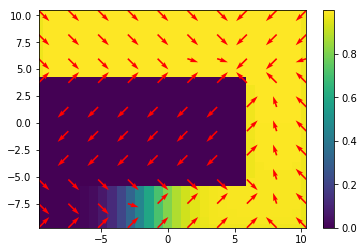

In [14]:
import best.policy as bp
reload(bp)

rpol = bp.RefinedPolicy(abstr, W, pol_sof)

xi, yi = np.meshgrid(*abstr.srep)

plt.pcolor(abstr.sedge[0], abstr.sedge[1],  W[:-1].reshape(xi.shape, order='F'))
plt.colorbar()
plt.xlim(np.array([abstr.srep[0][0],abstr.srep[0][-1]]))
plt.ylim(np.array([abstr.srep[1][0],abstr.srep[1][-1]]))
#plt.show()

xi, yi = np.meshgrid(np.linspace(abstr.srep[0][0],abstr.srep[0][-1],10),np.linspace(abstr.srep[1][0],abstr.srep[1][-1],10))

# compute inputs
u =sys_n.b.dot(rpol.cst(np.block([[xi.flatten()],[yi.flatten()]]) ))
delx = (-np.block([[xi.flatten()],[yi.flatten()]])
        +sys_n.a.dot(np.block([[xi.flatten()],[yi.flatten()]])) 
        + sys_n.b.dot(rpol.cst(np.block([[xi.flatten()],[yi.flatten()]]))))
x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(x_tr[0],x_tr[1],delx[0],delx[1], color = 'r')


6. Plot concrete systen


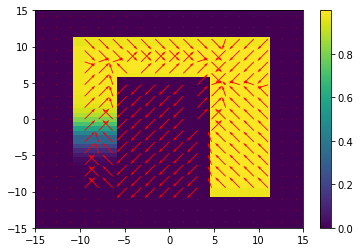

In [15]:
print('6. Plot concrete systen')
fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

values = rpol.val_concrete(np.block([[xi.flatten()], [yi.flatten()]]))
plt.pcolor(x_edge, y_edge, values.reshape(xi.shape))
plt.colorbar()
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

x_edge = np.linspace(-15,15,20)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,20)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

u = sys_lti.b.dot(rpol.cst(np.block([[xi.flatten()],[yi.flatten()]]),transformed = False))
delx = (-np.block([[xi.flatten()],[yi.flatten()]])
        +sys_lti.a.dot(np.block([[xi.flatten()],[yi.flatten()]])) 
        + sys_lti.b.dot(rpol.cst(np.block([[xi.flatten()],[yi.flatten()]]),transformed = False)))
x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(x_tr[0],x_tr[1],delx[0],delx[1], color = 'r')

('final state:', set([1]))
[[ 0.   0. ]
 [ 0.   0.4]]
Matrix is singular and may not have a square root.
reached
reached
reached
reached
reached
reached


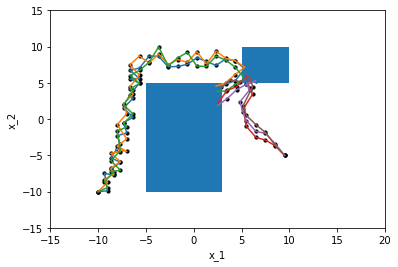

In [16]:
# how to get a nice simulation? 
from random import  gauss 
import random
import scipy.linalg as scla
import matplotlib

random.seed(a = '4')
print('final state:', dfsa_final)
time = 50
fig = plt.figure()
ax = fig.add_subplot(111)
print(sys_lti.W)
Wsqrt = scla.sqrtm(sys_lti.W)
for x0 in (np.array([[-10],[-10]]),np.array([[9.5],[-5]])):
    for repeating in range(3):
        rpol.reset()
        
        x = np.zeros((2,time+1))
        x[:,[0]] = x0

        for t in range(time): 
            x[:,[t+1]] = (sys_lti.a.dot(x[:,[t]])+sys_lti.b.dot(rpol(x[:,[t]], transformed=False )) 
                        + np.array(Wsqrt).dot(np.array([[gauss(0,1)],[gauss(0,1)]])))
            if rpol.finished() :
                print('reached')
                break
        if not rpol.finished():
            print('not reached')
        plt.plot(x[0,0:t+1],x[1,0:t+1])
        plt.scatter(x[0],x[1], label='Finite states', color='k', s=10, marker="o")

plt.xlabel('x_1') 
plt.ylabel('x_2') 

plt.xlim(np.array([-15,20]))
plt.ylim(np.array([-15,15]))
# Define regions of interest for the labeling
regions = dict()
regions['target'] = pc.box2poly(np.kron(np.ones((2, 1)), np.array([[5, 10]])))
# add avoid
regions['avoid'] = pc.box2poly(np.array([[-5, 3],[-10, 5]]))

x = pc.extreme(regions['target'])
y = pc.extreme(regions['avoid'])

patch = matplotlib.patches.Polygon(x)
ax.add_patch(patch)

patch = matplotlib.patches.Polygon(y)
ax.add_patch(patch)